## Brooklyn Nine-Nine Ratings Analysis

![title](b99.jpg)

### Project Goals
1. Successfully scrape episode info data from Wikipedia and ratings data from the AV club and IMDB for season 1 to season 6 of the popular TV show Brooklyn Nine-Nine.
2. Analyze if there are any gaps between critic ratings (from AV Club) and user ratings (from IMDB) for individual episodes as the show has progressed.
3. Explore features such as episode type (halloween heist episodes, pontaic bandit episodes, two-part episodes, etc.), writers, directors, number of US viewers who watched the episode the first time it aired, etc. to determine if we can predict the target variable i.e. the episode's IMDB rating to understand what episodes are liked the most by IMDB users. 

Let's start by importing all the libraries we'll need for scraping, cleaning, exploring, visualizing and modelling the data.

In [2]:
# import libraries
from urllib.request import urlopen as ureq
from bs4 import BeautifulSoup as soup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from wordcloud import WordCloud, STOPWORDS
import time

import dash
import dash_core_components as dcc
import dash_html_components as html
import plotly.graph_objs as go

### Episode Info from Wikipedia

#### Scraping data

In [3]:
# get html
url = "https://en.wikipedia.org/wiki/List_of_Brooklyn_Nine-Nine_episodes"
uclient = ureq(url)
page_html = uclient.read()
uclient.close()

# get episode data on page
page_soup = soup(page_html,"html.parser")
seasons = page_soup.findAll("table",{"class":"wikitable plainrowheaders wikiepisodetable"})
seasons = seasons[:-1]
seasons = seasons[:-1]

# store data in a pandas dataframe
column_names = ['prod_code','episode_title','directed_by','written_by','air_date','us_viewers','season_no','episode_no']
wiki_b99 = pd.DataFrame(columns=column_names)
for season in seasons:
    episodes = season.findAll("tr",{"class":"vevent"})
    for episode in episodes:
        wiki_b99 = wiki_b99.append({'prod_code': episode.findAll('td')[5].text, 'episode_title': episode.findAll('td')[1].text, 'directed_by': episode.findAll('td')[2].text, 'written_by': episode.findAll('td')[3].text, 'air_date': episode.findAll('td')[4].span.span.text, 'us_viewers': episode.findAll('td')[6].text}, ignore_index=True)

# clean columns
wiki_b99['episode_title'] = wiki_b99['episode_title'].str.replace('"','')
wiki_b99['us_viewers'] = wiki_b99['us_viewers'].str.split('[').str[0]

# clean data for title = 'The Fugitive'
wiki_b99 = wiki_b99[wiki_b99['episode_title']!='The Fugitive']
wiki_b99 = wiki_b99.append({'prod_code': '411', 'episode_title': 'The Fugitive: Part 1', 'directed_by': 'Rebecca Asher', 'written_by': 'Carol Kolb', 'air_date': '2017-01-01', 'us_viewers': '3.49'}, ignore_index=True)
wiki_b99 = wiki_b99.append({'prod_code': '412', 'episode_title': 'The Fugitive: Part 2', 'directed_by': 'Ryan Case', 'written_by': 'Justin Noble & Jessica Polonsky', 'air_date': '2017-01-01', 'us_viewers': '3.49'}, ignore_index=True)

wiki_b99['season_no'] = wiki_b99['prod_code'].str[:1]
wiki_b99['episode_no'] = wiki_b99['prod_code'].str[1:3]

#print(wiki_b99.shape)
#wiki_b99.head()

#### Creating additional columns

In [4]:
# create parts
column_names = ['air_date','parts']
parts = pd.DataFrame(columns=column_names)
parts['air_date'] = wiki_b99[wiki_b99.groupby('air_date')['air_date'].transform('size') > 1]['air_date'].unique()
parts['parts'] = '2'
wiki_b99 = pd.merge(wiki_b99,parts,on=['air_date'],how='left')
wiki_b99 = wiki_b99.fillna(1)

# create episode type
column_names = ['episode_title','episode_type']
data = [['Halloween','Halloween Episode'], ['Pontiac Bandit','Pontiac Bandit Episode'], ['Charges and Specs','Season Finale'], ['Undercover','Season Premiere'], ['Halloween II','Halloween Episode'], ['The Pontiac Bandit Returns','Pontiac Bandit Episode'], ['Johnny and Dora','Season Finale'], ['New Captain','Season Premiere'], ['Halloween III','Halloween Episode'], ['The Cruise','Pontiac Bandit Episode'], ['Greg and Larry','Season Finale'], ['Coral Palms: Part 1','Season Premiere'], ['Halloween IV','Halloween Episode'], ['The Fugitive: Part 2','Pontiac Bandit Episode'], ['Crime and Punishment','Season Finale'], ['The Big House: Part 1','Season Premiere'], ['HalloVeen','Halloween Episode'], ['99','99th Episode'], ['Game Night','100th Episode'], ['The Box','Bottle Episode'], ['Jake & Amy','Season Finale'], ['Honeymoon','Season Premiere'], ['A Tale of Two Bandits','Pontiac Bandit Episode'], ['Cinco de Mayo','Halloween Episode'], ['Suicide Squad','Season Finale']
]
episode_type = pd.DataFrame(data=data,columns=column_names)
wiki_b99 = pd.merge(wiki_b99,episode_type,on=['episode_title'],how='left')
wiki_b99 = wiki_b99.fillna('Normal Episode')

# create network
column_names = ['season_no','network']
data = [['1','Fox'], ['2','Fox'], ['3','Fox'], ['4','Fox'], ['5','Fox'], ['6','NBC']]
network = pd.DataFrame(data=data,columns=column_names)
wiki_b99 = pd.merge(wiki_b99,network,on=['season_no'],how='left')

# correct column datatypes
wiki_b99['air_date']=pd.to_datetime(wiki_b99['air_date'])
wiki_b99['us_viewers']=pd.to_numeric(wiki_b99['us_viewers'])

print(wiki_b99.shape)
wiki_b99.head()
#wiki_b99.to_csv('wiki_b99.csv')

(130, 11)


,prod_code,episode_title,directed_by,written_by,air_date,us_viewers,season_no,episode_no,parts,episode_type,network
0,101,Pilot,Phil Lord & Christopher Miller,Dan Goor & Michael Schur,2013-09-17,6.17,1,01,1,Normal Episode,Fox
1,102,The Tagger,Craig Zisk,Norm Hiscock,2013-09-24,4.03,1,02,1,Normal Episode,Fox
2,105,The Slump,Julie Anne Robinson,Prentice Penny,2013-10-01,3.43,1,05,1,Normal Episode,Fox
3,106,M.E. Time,Troy Miller,Gil Ozeri,2013-10-08,3.34,1,06,1,Normal Episode,Fox
4,104,The Vulture,Jason Ensler,Laura McCreary,2013-10-15,3.43,1,04,1,Normal Episode,Fox


We have successfully scraped the episode info data from wikipedia for all the 130 episodes across the 6 seasons. As season 7 hasn't finished airing yet, we will exclude that from our analysis.

We have also created additional descriptive variables such as episode type, parts and network.

#### Exploring Wikipedia Data 

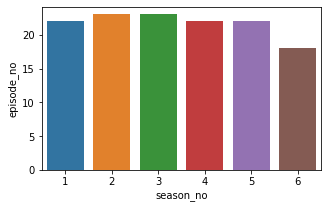

In [5]:
# episode count by season
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="season_no", y="episode_no", data=wiki_b99.groupby(['season_no']).count().reset_index())
# Seasons 1 to 5 have more than 20 episodes. 
# Season 6 has only 18 episodes as this was the season when the show moved from Fox to NBC and got a late premiere.

,written_by,episode_no
35,Luke Del Tredici,13
14,David Phillips,8
32,Laura McCreary,7
45,Phil Augusta Jackson,7
25,Justin Noble,5
40,Neil Campbell,5
18,Gabe Liedman,5
10,Carol Kolb,5
11,Dan Goor,4
47,Prentice Penny,4


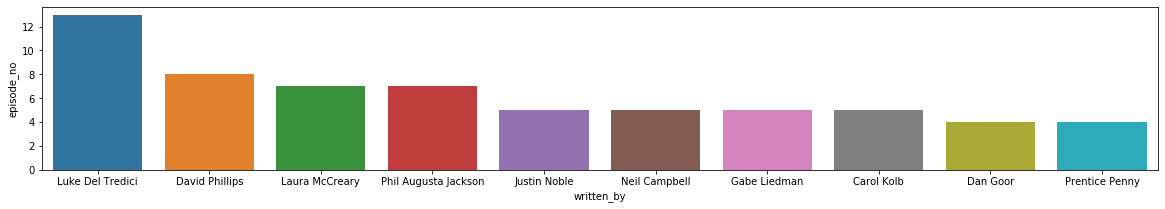

In [6]:
# episode count by writer
fig, ax = plt.subplots(1,1,figsize=(20,3))
sns.barplot(x="written_by", y="episode_no", data=wiki_b99.groupby(['written_by']).count().reset_index().sort_values(by='episode_no',ascending=False).head(10))
wiki_b99.groupby(['written_by']).count().reset_index().sort_values(by='episode_no',ascending=False).head(10)[['written_by','episode_no']]
# Writer Luke Del Tredici wrote 10% (13/130) of the episodes.
# The top 10 writers combined wrote 48% of the episodes.

,directed_by,episode_no
33,Michael McDonald,10
25,Linda Mendoza,7
9,Dean Holland,7
5,Claire Scanlon,6
48,Tristram Shapeero,5
7,Craig Zisk,5
37,Payman Benz,4
43,Rebecca Asher,4
10,Eric Appel,4
52,"Victor Nelli, Jr.",4


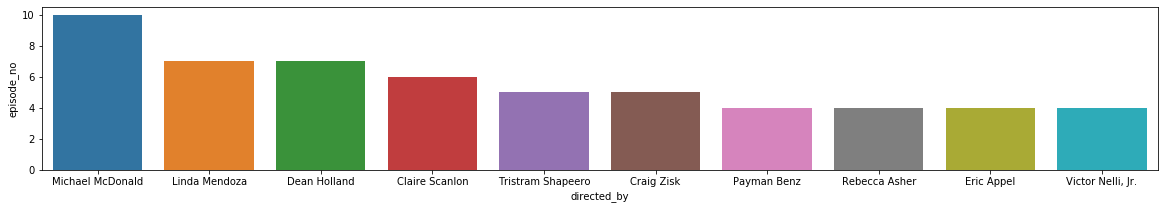

In [7]:
# episode count by director
fig, ax = plt.subplots(1,1,figsize=(20,3))
sns.barplot(x="directed_by", y="episode_no", data=wiki_b99.groupby(['directed_by']).count().reset_index().sort_values(by='episode_no',ascending=False).head(10))
wiki_b99.groupby(['directed_by']).count().reset_index().sort_values(by='episode_no',ascending=False).head(10)[['directed_by','episode_no']]

# Director Michael McDonald directed 8% (10/130) episodes.
# The top 10 directors combined directed 43% of the episodes.

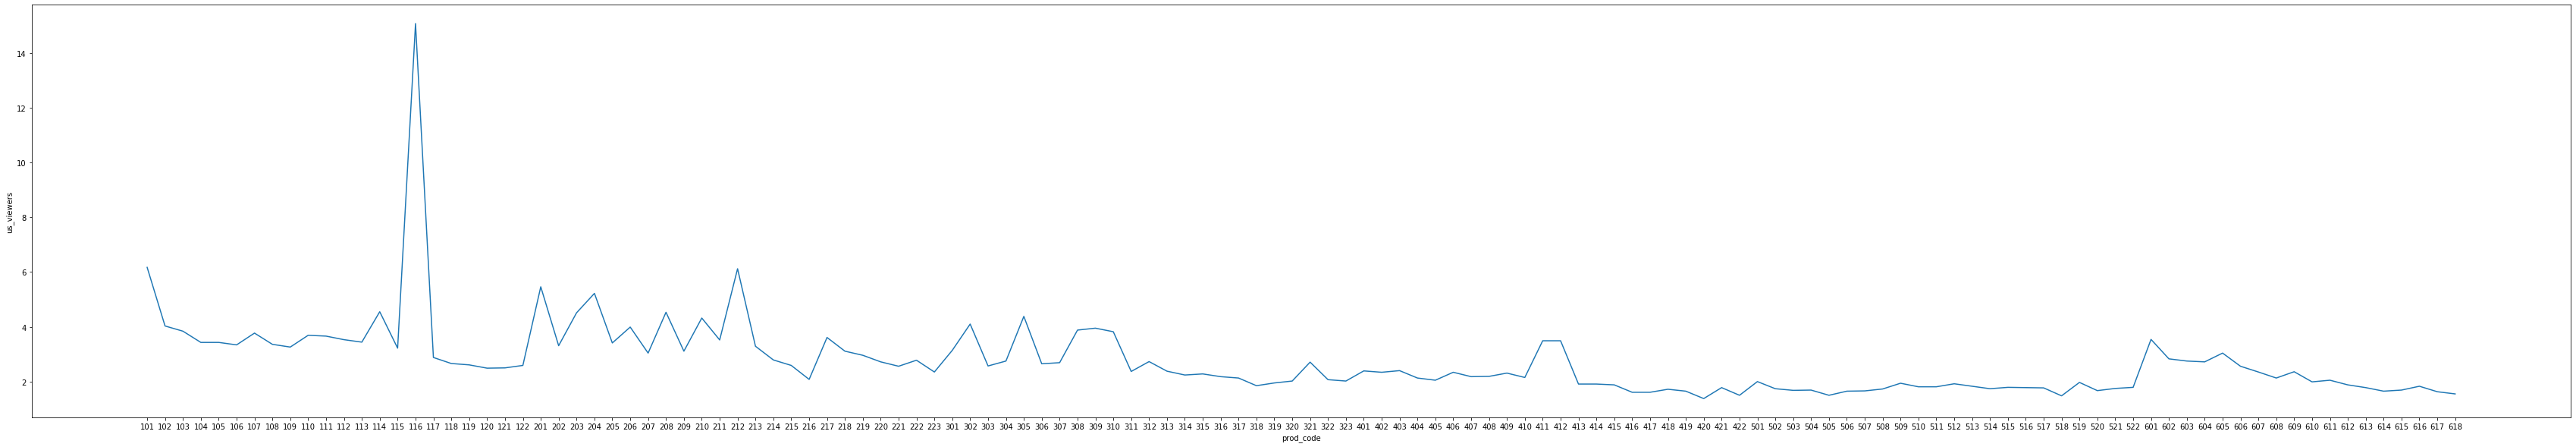

In [8]:
# total US viewers by season and episode
fig, ax = plt.subplots(1,1,figsize=(60,10))
sns.lineplot(x="prod_code", y="us_viewers", data=wiki_b99.groupby(['prod_code']).sum().reset_index())
# US viewers shows a decreasing trend with spikes for certain episodes. 
# S01E15-Operation: Broken Feather was watched approximately 15 million US viewers which is unusally high for the show. This episode was written by show creator Dan Goor & Michael Schur.
# S06E01-Honeymoon shows a spike in US viewers. This was when the show moved from Fox to NBC. 
# S06E01-Honeymoon was watched by twice as many US viewers as the previous episode S05E22-Jake & Amy.

,season_no,us_viewers
0,1,3.978182
1,2,3.538261
2,3,2.733043
3,4,2.109545
4,5,1.759091
5,6,2.240556


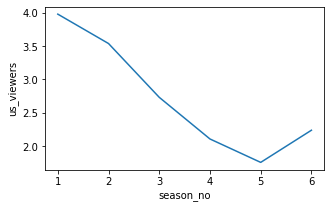

In [9]:
# average US viewers by season
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.lineplot(x="season_no", y="us_viewers", data=wiki_b99.groupby(['season_no']).mean().reset_index())
wiki_b99.groupby(['season_no']).mean().reset_index()
# We observe that the average US viewers decreases from season 1 to season 5 and then increases 1.27 times in season 6 compared to season 5. 
# The show became really popular when season 6 was airing as its cancellation after season 5 by Fox was a hot discussion topic on Reddit and Twitter leading to a lot of word-of-mouth marketing.

,network,us_viewers
0,Fox,2.829196
1,NBC,2.240556


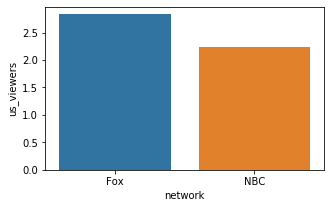

In [10]:
# average US viewers by network
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="network", y="us_viewers", data=wiki_b99.groupby(['network']).mean().reset_index())
wiki_b99.groupby(['network']).mean().reset_index()
# The show had 1.26 times more average US viewers when it aired on Fox than when it aired on NBC.

,episode_type,us_viewers
0,100th Episode,1.810000
1,99th Episode,1.940000
2,Bottle Episode,1.780000
3,Halloween Episode,3.156667
4,Normal Episode,2.740286
5,Pontiac Bandit Episode,3.334000
6,Season Finale,1.966667
7,Season Premiere,3.306000


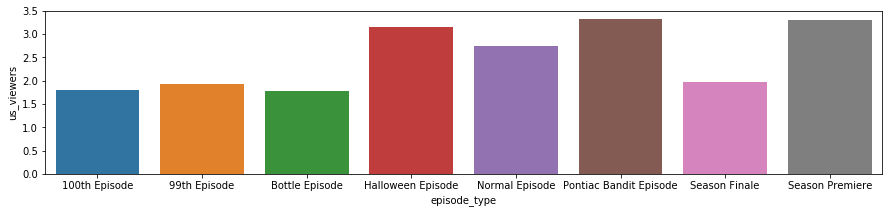

In [11]:
# average US viewers by episode type
fig, ax = plt.subplots(1,1,figsize=(15,3))
sns.barplot(x="episode_type", y="us_viewers", data=wiki_b99.groupby(['episode_type']).mean().reset_index())
wiki_b99.groupby(['episode_type']).mean().reset_index()
# The show's 99th and 100th episode had approximately 2/3rd of the normal viewership count.
# Season premiere episodes have 20.66% more average US viewers than normal episodes. 
# Season finale episodes have 28.2% less average US viewers than that of normal episodes.
# Halloween heist episodes have 15.19% more average US viewers than normal episodes.
# Pontaic bandit episodes starring guest star 'Craig Robinson' have 21.67% more average US viewers than normal episodes.

,parts,us_viewers
0,1,2.850172
1,2,1.898571


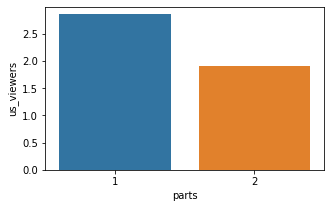

In [12]:
# average US viewers by parts
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="parts", y="us_viewers", data=wiki_b99.groupby(['parts']).mean().reset_index())
wiki_b99.groupby(['parts']).mean().reset_index()
# We expect that two-part episodes that are aired back-to-back would pull in more viewers but that's not true.
# Single episodes have 1.5 times the average US viewers than two-part episodes.

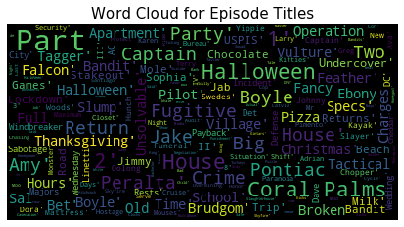

In [13]:
# word cloud for episode titles
plt.figure(figsize = (7,7))
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                      background_color = 'black',
                      stopwords=stopwords,
                      max_words = 10000,
                      max_font_size = 30,
                      random_state = 42
                    ).generate(str(wiki_b99['episode_title'].values))

plt.imshow(wordcloud)
plt.title("Word Cloud for Episode Titles", fontsize = 15)
plt.axis('off')
plt.show()
# Detective Charles Boyle's last name 'Boyle' is among the commonly used words in episode titles.


### Critic Ratings from The A.V. Club

#### Scraping data

In [14]:
# fetch data for 20 episodes per season
column_names = ['season_no','air_date','avclub_rating']
av_club_b99 = pd.DataFrame(columns=column_names)
    
for i in range(1,7):
    # get html
    url = "https://www.avclub.com/c/tv-review/brooklyn-nine-nine/season-"+str(i)
    uclient = ureq(url)
    page_html = uclient.read()
    uclient.close()
    
    # get articles on page
    page_soup = soup(page_html,"html.parser")
    articles = page_soup.findAll("article",{"class":"js_post_item cw4lnv-0 glgzMx"})
    
    # store data in a pandas dataframe
    for article in articles:
        av_club_b99 = av_club_b99.append({'season_no': i, 'avclub_rating': article.figure.div.div.text, 'air_date': article.div.findAll("div",{"class":"sc-3nbvzd-1 VhErj"})[0].text}, ignore_index=True)

av_club_b99['air_date'] = pd.to_datetime(av_club_b99['air_date'])

#print(av_club_b99.shape)
#av_club_b99.head()

In [15]:
# fetch data for remaining episodes per season
# get min date per season
av_club_b99_date = av_club_b99.groupby('season_no').agg({'air_date':['min']})['air_date','min']

for i in range(1,7):
    # convert min date to epoch timestamp in milliseconds
    date_time = av_club_b99_date
    pattern = '%Y-%m-%d %H:%M:%S'
    av_club_b99_epoch = int(time.mktime(time.strptime(str(date_time[i]), pattern)))
    
    # get html
    url = "https://www.avclub.com/c/tv-review/brooklyn-nine-nine/season-"+str(i)+'?startTime='+str(av_club_b99_epoch*1000)
    uclient = ureq(url)
    page_html = uclient.read()
    uclient.close()
    
    # get articles on page
    page_soup = soup(page_html,"html.parser")
    articles = page_soup.findAll("article",{"class":"js_post_item cw4lnv-0 glgzMx"})
    
    # store data in a pandas dataframe (av_club_b99)
    for article in articles:
        av_club_b99 = av_club_b99.append({'season_no': i, 'avclub_rating': article.figure.div.div.text, 'air_date': article.div.findAll("div",{"class":"sc-3nbvzd-1 VhErj"})[0].text}, ignore_index=True)
        
av_club_b99['air_date'] = pd.to_datetime(av_club_b99['air_date'])

print(av_club_b99.shape)
av_club_b99.head()

(123, 3)


,season_no,air_date,avclub_rating
0,1,2014-03-25,A
1,1,2014-03-19,B+
2,1,2014-03-12,A-
3,1,2014-03-04,A-
4,1,2014-02-26,B-


We have successfully scraped the AV Club ratings data for 123 episodes across the 6 seasons. We observe that the ratings data is not fetched correctly for two-part episodes. We manually enter the data for these episodes in a csv file as the ratings stored at different locations on the webpage and it would to be too time-consuming to write code to scrape that data.

#### Cleaning data

In [16]:
# remove air dates with missing ratings
av_club_b99 = av_club_b99[av_club_b99['avclub_rating']!='']

#print(av_club_b99.shape)
#av_club_b99.head()

#### Combining AV Club Ratings Data with Wikipedia Episode Info Data

In [17]:
combined = pd.merge(wiki_b99, av_club_b99[['air_date','avclub_rating']], on='air_date', how='left')

av_club_b99['air_date1'] = av_club_b99['air_date'] - pd.DateOffset(1)

combined=pd.merge(combined, av_club_b99[['air_date1','avclub_rating']], left_on='air_date', right_on='air_date1', how='left')

combined['avclub_rating_x'] = combined['avclub_rating_x'].fillna(combined['avclub_rating_y'])

# manually aggregate missing AV Club ratings data
avclub_ratings_missing = pd.read_csv('avclub_ratings_missing.csv', dtype={'prod_code': object})

combined=pd.merge(combined, avclub_ratings_missing, on='prod_code', how='left')
combined['avclub_rating'] = combined['avclub_rating'].fillna(combined['avclub_rating_x'])

combined = combined.drop(columns=['avclub_rating_x', 'air_date1', 'avclub_rating_y'])

print(combined.shape)
combined.head()

(130, 12)


,prod_code,episode_title,directed_by,written_by,air_date,us_viewers,season_no,episode_no,parts,episode_type,network,avclub_rating
0,101,Pilot,Phil Lord & Christopher Miller,Dan Goor & Michael Schur,2013-09-17,6.17,1,01,1,Normal Episode,Fox,B+
1,102,The Tagger,Craig Zisk,Norm Hiscock,2013-09-24,4.03,1,02,1,Normal Episode,Fox,B
2,105,The Slump,Julie Anne Robinson,Prentice Penny,2013-10-01,3.43,1,05,1,Normal Episode,Fox,B+
3,106,M.E. Time,Troy Miller,Gil Ozeri,2013-10-08,3.34,1,06,1,Normal Episode,Fox,B
4,104,The Vulture,Jason Ensler,Laura McCreary,2013-10-15,3.43,1,04,1,Normal Episode,Fox,A-


We observe that the AV Club gives letter ratings instead of number ratings but we know that IMDB users give number ratings. For consistency and to easily compare the two ratings, we map the letter ratings to their corresponding number ratings.

In [18]:
column_names = ['rating_letter','rating_num']
data = [['A',10], ['A-',9], ['B+',8], ['B',7], ['B-',6], ['C+',5], ['C',4], ['C-',3], ['D+',2], ['D',1]]
av_club_rating = pd.DataFrame(data,columns = column_names)
av_club_rating

combined = pd.merge(combined, av_club_rating, left_on='avclub_rating',right_on='rating_letter')
combined['avclub_rating'] = combined['rating_num']

combined = combined.drop(columns=['rating_letter', 'rating_num'])

#print(combined.shape)
#combined.head()

#### Exploring AV CLub data

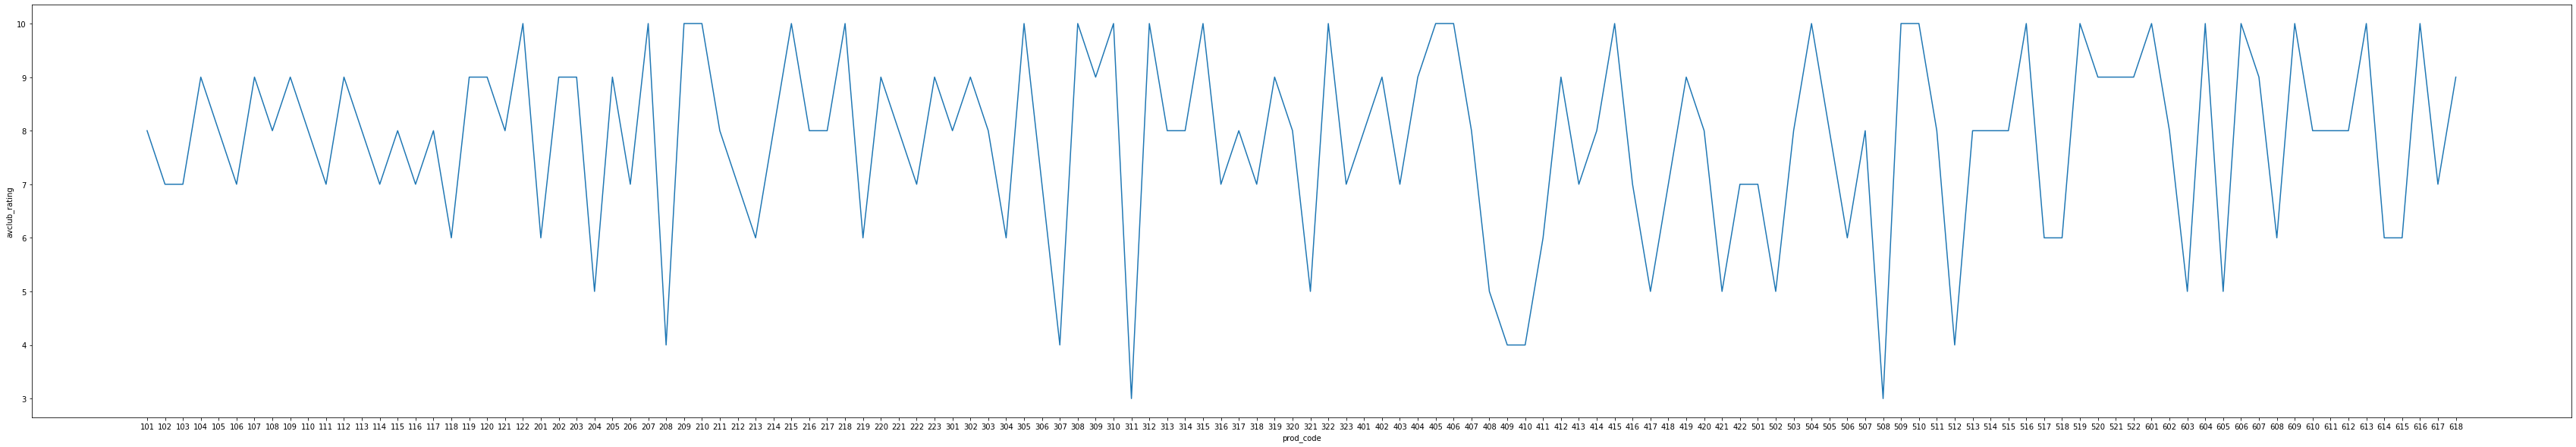

In [19]:
# AV Club ratings by season and episode
fig, ax = plt.subplots(1,1,figsize=(60,10))
sns.lineplot(x="prod_code", y="avclub_rating", data=combined.groupby(['prod_code']).sum().reset_index())
# The critic ratings for the show fluctuate a lot over the seasons. 
# The largest critic rating drops are during or near the mid-season.

,season_no,avclub_rating
0,1,8.000000
1,2,7.956522
2,3,7.869565
3,4,7.363636
4,5,7.727273
5,6,8.055556


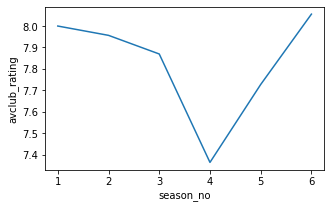

In [20]:
# average AV club ratings by season
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.lineplot(x="season_no", y="avclub_rating", data=combined.groupby(['season_no']).mean().reset_index())
combined.groupby(['season_no']).mean().reset_index()[['season_no','avclub_rating']]
# The critic ratings decrease from seasons 1 to 4 and then increase from seasons 4 to 6
# Season 6's average critic rating is slightly higher than season 1's average critic rating.

,network,avclub_rating
0,Fox,7.785714
1,NBC,8.055556


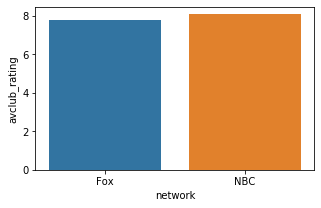

In [21]:
# average AV Club ratings by network
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="network", y="avclub_rating", data=combined.groupby(['network']).mean().reset_index())
combined.groupby(['network']).mean().reset_index()[['network','avclub_rating']]
# The critic ratings are similar for both networks.

,episode_type,avclub_rating
0,100th Episode,10.000000
1,99th Episode,10.000000
2,Bottle Episode,10.000000
3,Halloween Episode,9.000000
4,Normal Episode,7.647619
5,Pontiac Bandit Episode,8.000000
6,Season Finale,8.500000
7,Season Premiere,7.800000


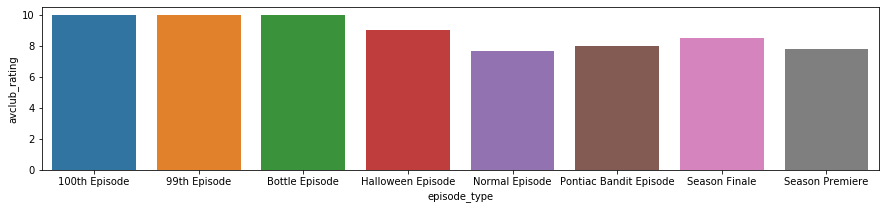

In [22]:
# average AV Club rating by episode type
fig, ax = plt.subplots(1,1,figsize=(15,3))
sns.barplot(x="episode_type", y="avclub_rating", data=combined.groupby(['episode_type']).mean().reset_index())
combined.groupby(['episode_type']).mean().reset_index()[['episode_type','avclub_rating']]
# The show's 100th episode, 99th episode and the bottle episode received perfect 10/10 ratings from critics.
# Season premiere episodes are only considered slightly better than normal episodes by critics
# Season finales receive 11% higher ratings from critics compared to normal episodes.
# Halloween heist episodes have on an average received the second best critic rating of 9.
# Pontaic bandit episodes have on an average received the third best critic rating of 8.

,parts,avclub_rating
0,1,7.870690
1,2,7.428571


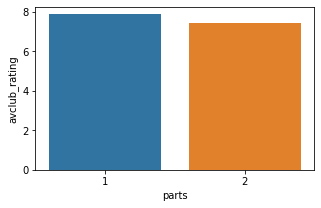

In [23]:
# average AV club ratings by parts
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="parts", y="avclub_rating", data=combined.groupby(['parts']).mean().reset_index())
combined.groupby(['parts']).mean().reset_index()[['parts','avclub_rating']]
# Critic ratings are similar for single episodes and two-part episodes.

### User Ratings from IMDB

In [24]:
column_names = ['season_no','episode_no','air_date','imdb_rating','episode_title','total_votes']
imdb_b99 = pd.DataFrame(columns=column_names)

for i in range(1,7):
    # get html
    url = "https://www.imdb.com/title/tt2467372/episodes?season="+str(i)
    uclient = ureq(url)
    page_html = uclient.read()
    uclient.close()
    
    # get episode data on page
    page_soup = soup(page_html,"html.parser")
    episodes = page_soup.findAll("div",{"class":"info"})
    
    # store data in a pandas dataframe
    for episode in episodes:
        imdb_b99 = imdb_b99.append({'season_no':i,'episode_no':episode.meta['content'], 'air_date': episode.findAll("div",{"class":"airdate"})[0].text, 'imdb_rating': episode.findAll("span",{"class":"ipl-rating-star__rating"})[0].text, 'episode_title':episode.a['title'],'total_votes':episode.findAll("span",{"class":"ipl-rating-star__total-votes"})[0].text}, ignore_index=True)

imdb_b99['imdb_rating'] = pd.to_numeric(imdb_b99['imdb_rating'])
imdb_b99['air_date'] = pd.to_datetime(imdb_b99['air_date'].replace('\n', '').str.strip())
imdb_b99['total_votes'] = pd.to_numeric(imdb_b99['total_votes'].str[1:6].str.replace(',',''))
imdb_b99['prod_code'] = imdb_b99['season_no'].astype(str)+('0'+imdb_b99['episode_no']).str[-2:]
imdb_b99['imdb_rating_show'] = 8.4
imdb_b99['total_votes_show'] = 187619

print(imdb_b99.shape)
imdb_b99.head()

(130, 9)


,season_no,episode_no,air_date,imdb_rating,episode_title,total_votes,prod_code,imdb_rating_show,total_votes_show
0,1,1,2013-09-17,7.8,Pilot,3311,101,8.4,187619
1,1,2,2013-09-24,7.6,The Tagger,2689,102,8.4,187619
2,1,3,2013-10-01,7.6,The Slump,2512,103,8.4,187619
3,1,4,2013-10-08,7.8,M.E. Time,2440,104,8.4,187619
4,1,5,2013-10-15,8.0,The Vulture,2350,105,8.4,187619


We have successfully scraped the ratings data from IMDB for all 130 episodes across the 6 seasons.

#### Combining IMDB Ratings Data with AV Club Ratings Data and Episode Info Data from Wikipedia

In [25]:
combined = pd.merge(combined, imdb_b99[['prod_code','imdb_rating','total_votes','imdb_rating_show','total_votes_show']], on='prod_code',how='left')

print(combined.shape)
combined.head()

(130, 16)


,prod_code,episode_title,directed_by,written_by,air_date,us_viewers,season_no,episode_no,parts,episode_type,network,avclub_rating,imdb_rating,total_votes,imdb_rating_show,total_votes_show
0,101,Pilot,Phil Lord & Christopher Miller,Dan Goor & Michael Schur,2013-09-17,6.17,1,01,1,Normal Episode,Fox,8,7.8,3311,8.4,187619
1,105,The Slump,Julie Anne Robinson,Prentice Penny,2013-10-01,3.43,1,05,1,Normal Episode,Fox,8,8.0,2350,8.4,187619
2,108,Sal's Pizza,Craig Zisk,Lakshmi Sundaram,2013-11-19,3.36,1,08,1,Normal Episode,Fox,8,7.8,2216,8.4,187619
3,110,Thanksgiving,Jorma Taccone,Luke Del Tredici,2013-11-26,3.69,1,10,1,Normal Episode,Fox,8,8.3,2207,8.4,187619
4,113,Pontiac Bandit,Craig Zisk,Norm Hiscock & Lakshmi Sundaram,2014-01-07,3.44,1,13,1,Pontiac Bandit Episode,Fox,8,8.8,2447,8.4,187619


#### Exploring IMDB Ratings Data

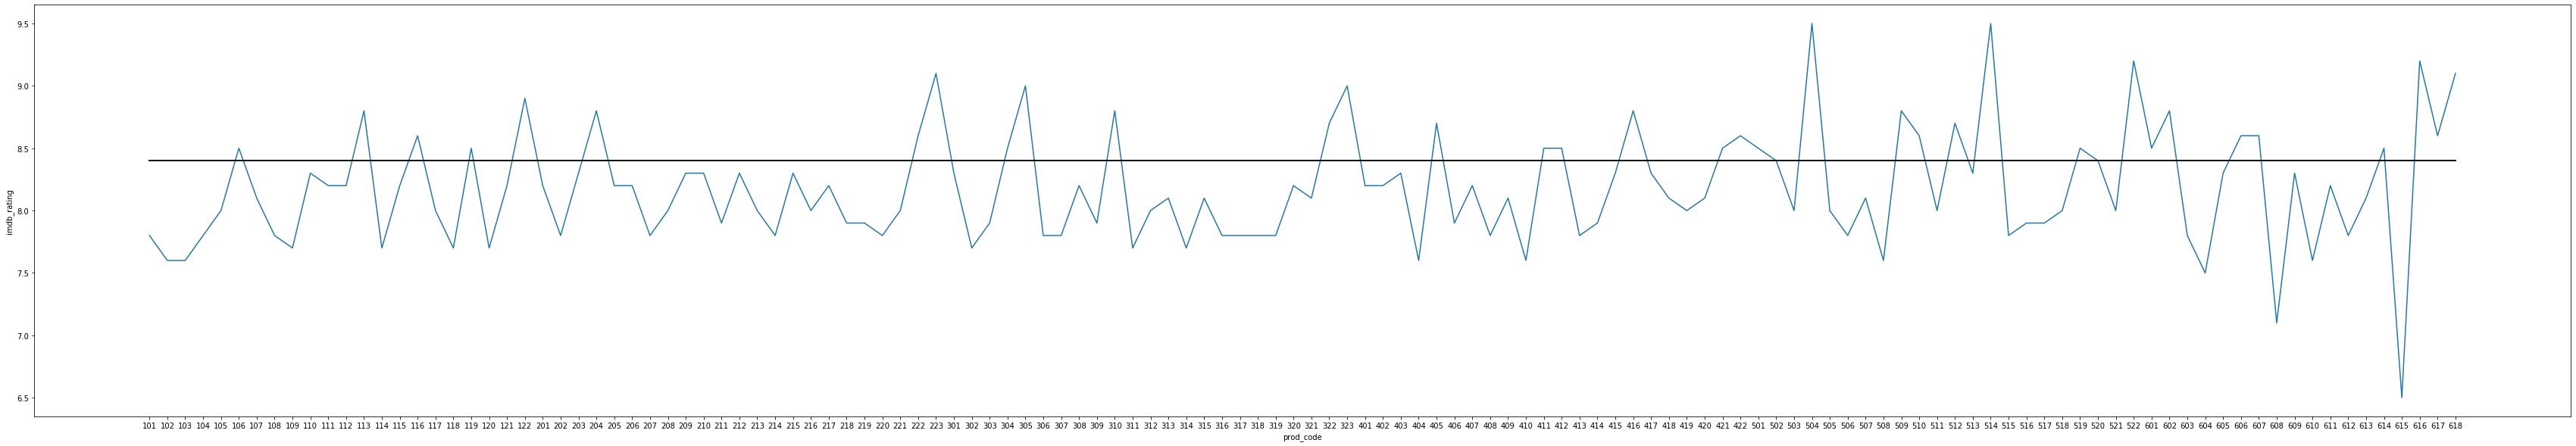

In [26]:
# IMDB ratings by season and episode
fig, ax = plt.subplots(1,1,figsize=(60,10))
sns.lineplot(x="prod_code", y="imdb_rating", data=combined.groupby(['prod_code']).sum().reset_index())
plt.plot('prod_code', 'imdb_rating_show', data=combined, marker='', color='black', linewidth=2)
# 30 episodes have higher user ratings than the show's overall IMDB rating which is 8.4.
# The user ratings for the show fluctuate a lot over the seasons and episodes. 
# The largest user rating drop is observed during S06E15-Return of the King which has a rating of 6.5. This episode marks the return of the slightly controversial character Gina Linetti potrayed by Chelsea Peretti who left in S06E04-Four Movements.

,network,imdb_rating
0,Fox,8.176786
1,NBC,8.172222


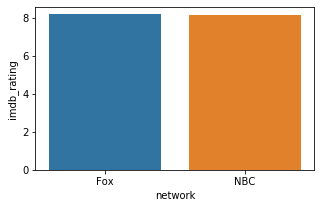

In [27]:
# average IMDB ratings by network
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="network", y="imdb_rating", data=combined.groupby(['network']).mean().reset_index())
combined.groupby(['network']).mean().reset_index()[['network','imdb_rating']]
# The average user rating is similar for both networks.

,season_no,imdb_rating
0,1,8.086364
1,2,8.160870
2,3,8.117391
3,4,8.181818
4,5,8.340909
5,6,8.172222


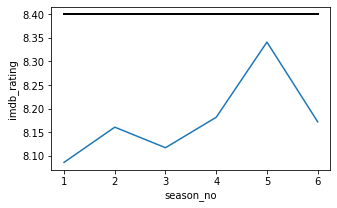

In [28]:
# average IMDB ratings by season
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.lineplot(x="season_no", y="imdb_rating", data=combined.groupby(['season_no']).mean().reset_index())
plt.plot('season_no', 'imdb_rating_show', data=combined, marker='', color='black', linewidth=2)
combined.groupby(['season_no']).mean().reset_index()[['season_no','imdb_rating']]
# Season 5 is the most liked season by users
# The average user rating for all seasons is below the show's overall IMDB rating which is 8.4.

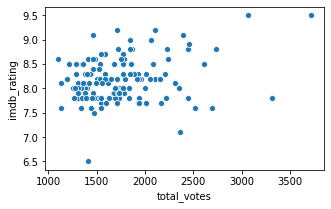

In [34]:
# total votes vs total ratings
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.scatterplot('total_votes','imdb_rating',data=combined)
# most episodes receive between 1500 to 2500 total votes
# most episodes receive ratings between 7.5 and 8.5 by users on IMDB

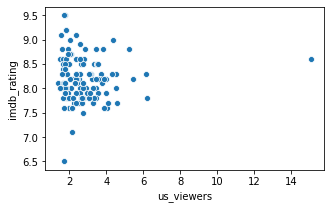

In [29]:
# total US viewers vs total ratings
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.scatterplot('us_viewers','imdb_rating',data=combined)
# most episodes have US viewers between 2 and 3 million
# most episodes receive ratings between 7.5 and 8.5 by users on IMDB

,episode_type,imdb_rating
0,100th Episode,8.600000
1,99th Episode,8.800000
2,Bottle Episode,7.900000
3,Halloween Episode,8.883333
4,Normal Episode,8.063810
5,Pontiac Bandit Episode,8.400000
6,Season Finale,8.983333
7,Season Premiere,8.340000


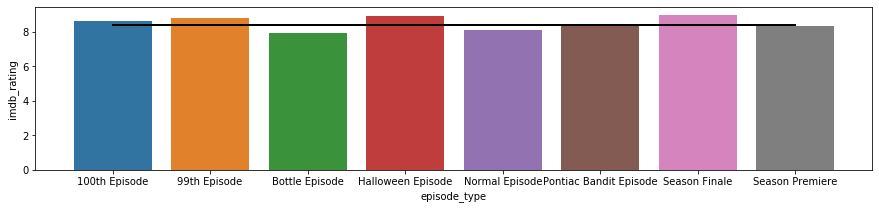

In [35]:
# average IMDB ratings by episode type
fig, ax = plt.subplots(1,1,figsize=(15,3))
sns.barplot(x="episode_type", y="imdb_rating", data=combined.groupby(['episode_type']).mean().reset_index())
plt.plot('episode_type', 'imdb_rating_show', data=combined, marker='', color='black', linewidth=2)
combined.groupby(['episode_type']).mean().reset_index()[['episode_type','imdb_rating']]
# Season premiere episodes receive 3.43% higher average user ratings than normal episodes
# Season finale episodes receive 11.40% higher average user ratings than normal episodes
# Halloween heist episodes receive 10.16% higher average user ratings than normal episodes 
# Pontaic bandit episodes receive 4.17% higher average user ratings than normal episodes.
# The 100th episode, 99th episode, halloween heist episodes and season finale episodes have higher user ratings than the show's overall IMDB rating which is 8.4.

,parts,imdb_rating
0,1,8.150862
1,2,8.385714


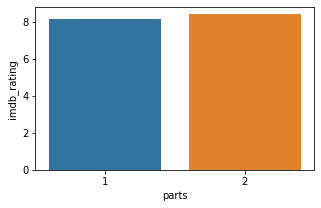

In [36]:
# average IMDB ratings by parts
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="parts", y="imdb_rating", data=combined.groupby(['parts']).mean().reset_index())
combined.groupby(['parts']).mean().reset_index()[['parts','imdb_rating']]
# Two-part episodes receive slightly higher ratings than single episodes.

### Exploratory Data Analysis on Combined Data

#### Rating Gap Analysis

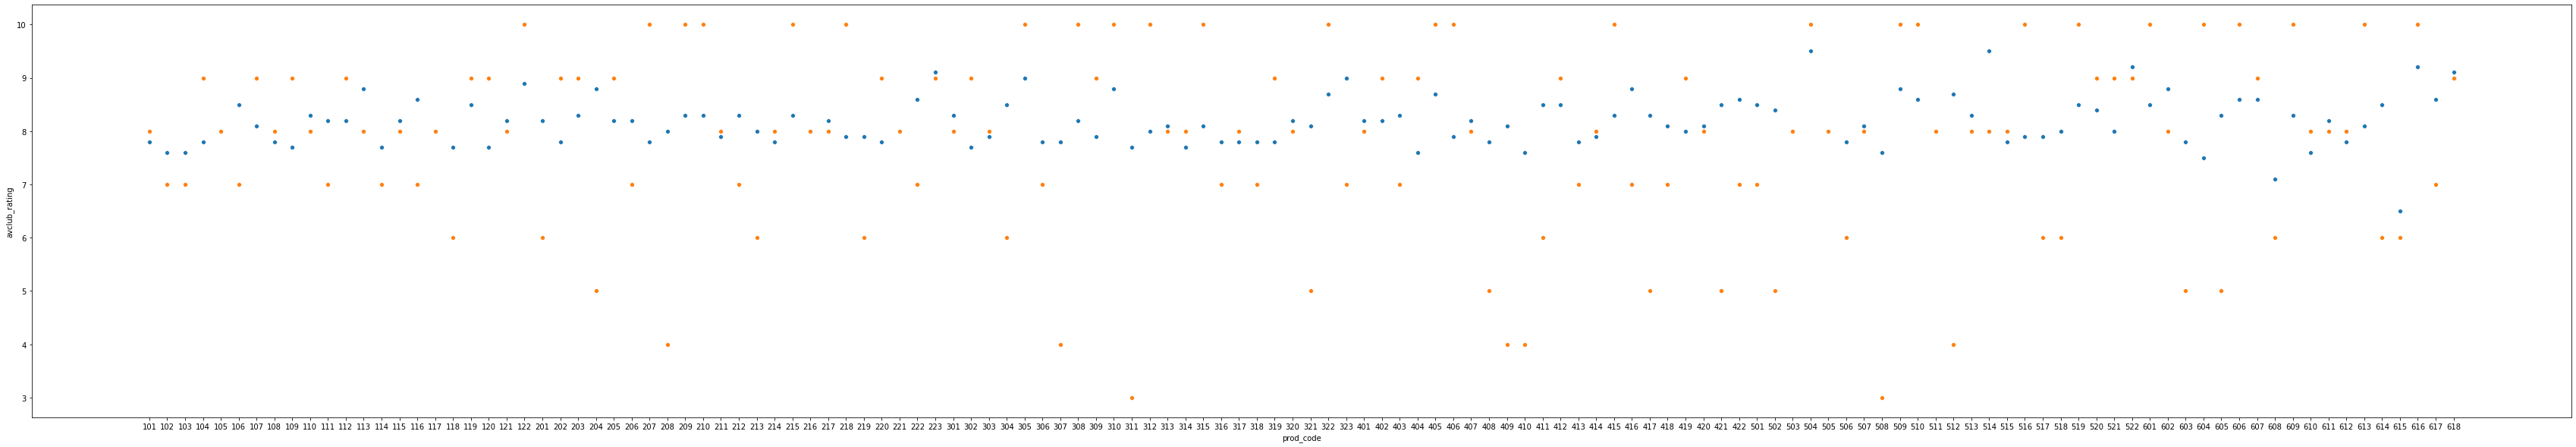

In [37]:
# AV Club ratings and IMDB rating by season and episode
fig, ax = plt.subplots(1,1,figsize=(60,10))
sns.scatterplot(x="prod_code", y="imdb_rating", data=combined.groupby(['prod_code']).sum().reset_index()) # blue
sns.scatterplot(x="prod_code", y="avclub_rating", data=combined.groupby(['prod_code']).sum().reset_index()) # orange
# Huge gaps are observed for certain episodes between the user ratings (blue dots) and critic ratings (orange dots)

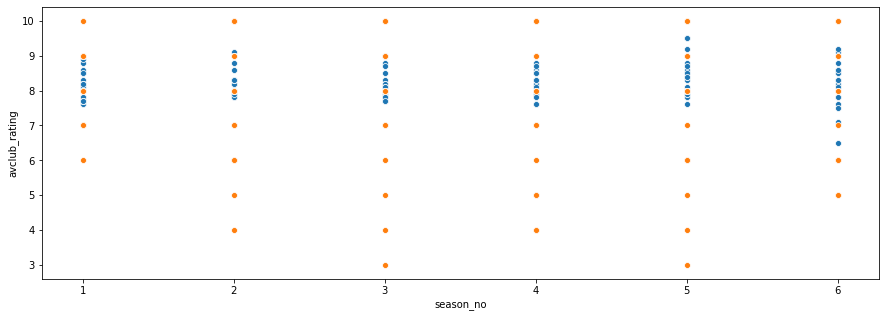

In [38]:
# AV Club ratings and IMDB rating by season and episode
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.scatterplot(x="season_no", y="imdb_rating", data=combined) # blue
sns.scatterplot(x="season_no", y="avclub_rating", data=combined) # orange
# Critic ratings (orange dots) have a wider distribution than the IMDB ratings (blue dots)

In [39]:
# create rating difference
combined['rating_diff'] = combined['avclub_rating'] - combined['imdb_rating']
combined['rating_diff_flag'] = np.where(combined['rating_diff']<0,'users rated higher','users rated lower/same')
# The rating difference is positive when AV Club ratings are higher than IMDB ratings and vice versa.

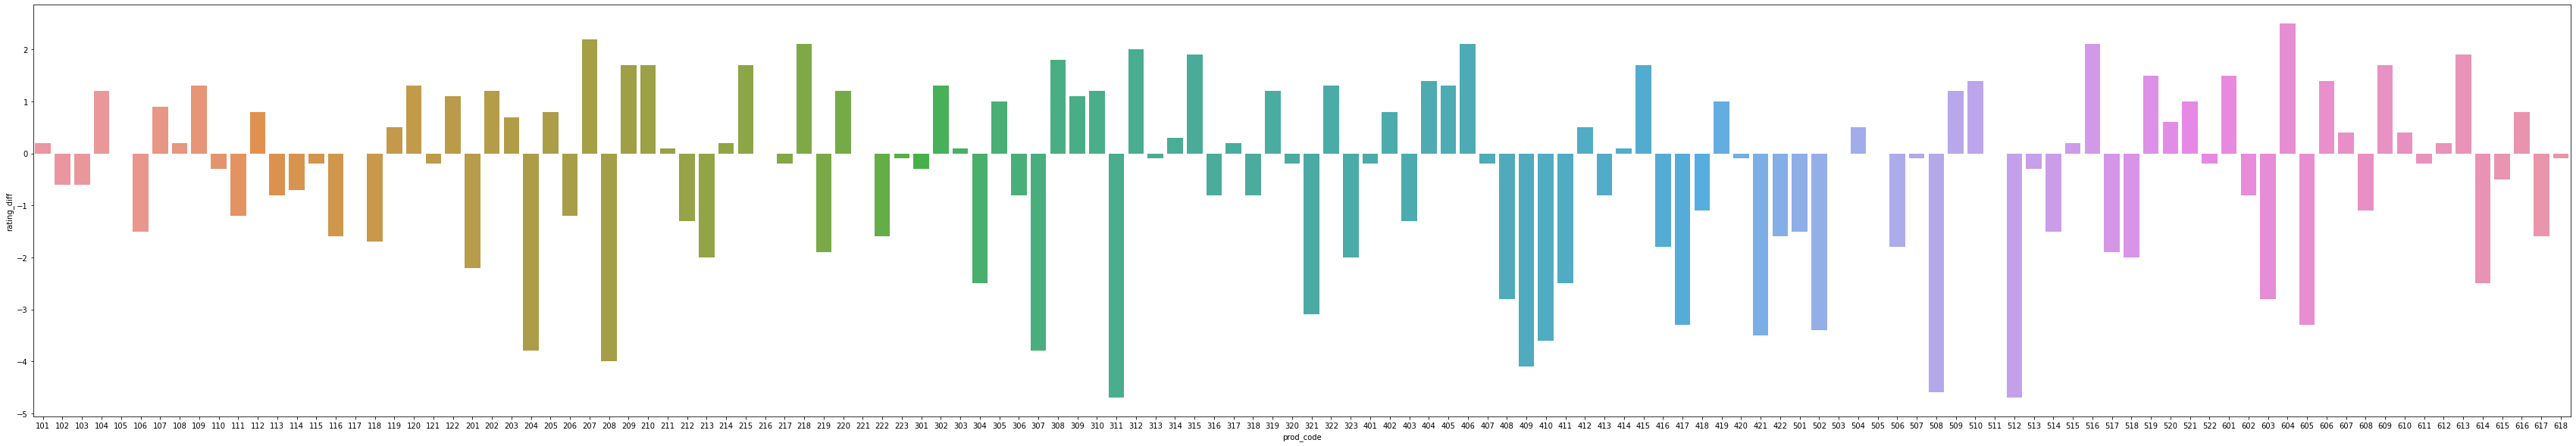

In [40]:
# rating difference by season and episode
fig, ax = plt.subplots(1,1,figsize=(60,10))
sns.barplot(x="prod_code", y="rating_diff", data=combined.groupby(['prod_code']).sum().reset_index())
# Huge negative rating differences are observed as the show has progressed
# Users rated later episodes of the show higher than critics.

,rating_diff_flag,episode_no
0,users rated higher,66
1,users rated lower/same,64


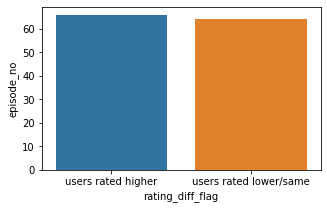

In [41]:
# episode count by rating difference flag
fig, ax = plt.subplots(1,1,figsize=(5,3))
sns.barplot(x="rating_diff_flag", y="episode_no", data=combined.groupby(['rating_diff_flag']).count().reset_index())
combined.groupby(['rating_diff_flag']).count().reset_index()[['rating_diff_flag','episode_no']]
# 66 out of the total 130 episodes are rated higher by users compared to critics.

In [42]:
# create rating tag
def rating_tag(c):
  if c['imdb_rating']>=7 and c['avclub_rating']>=7:
    return 'High IMDB High AV Club'
  elif c['imdb_rating']<7 and c['avclub_rating']>=7:
    return 'Low IMDB High AV Club'
  elif c['imdb_rating']>=7 and c['avclub_rating']<7:
    return 'High IMDB Low AV Club'
  else:
    return 'Low IMDB Low AV Club'

combined['rating_tag'] = combined.apply(rating_tag, axis=1)

,rating_tag,episode_no
0,High IMDB High AV Club,103
1,High IMDB Low AV Club,26
2,Low IMDB Low AV Club,1


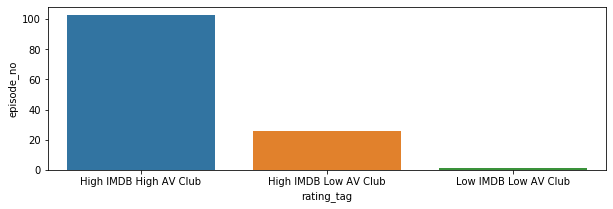

In [43]:
# episode count by rating difference flag
fig, ax = plt.subplots(1,1,figsize=(10,3))
sns.barplot(x="rating_tag", y="episode_no", data=combined.groupby(['rating_tag']).count().reset_index())
combined.groupby(['rating_tag']).count().reset_index()[['rating_tag','episode_no']]
# 103 out of the total 130 episodes are highly rated (rating => 7) by both critics and users
# Only 1 episode of the show is not highly rated (rating < 7) by both critics and users
# The remaining 26 episodes are highly rated by users but not critics

### IMDB Rating Prediction Model

#### Possible features to predict IMDB ratings

From EDA, we can conclude that network and parts don't have much impact on episode ratings.

We can use US viewers, writers, directors and episode type as features to predict IMDB ratings.

As there are 51 writers and 53 directors, there would be too many dummy variables in our model. Thus, we finalize on US viewers and episode type as features.

#### Encoding categorical variables

In [59]:
cat_cols = combined[['episode_type']]

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(cat_cols)
cat_cols_1hot = encoder.transform(cat_cols)
cat_cols_1hot_df = pd.DataFrame(cat_cols_1hot, columns = encoder.get_feature_names())
cat_cols_1hot_df
df = pd.concat([combined,cat_cols_1hot_df],axis=1)
df.head()

,prod_code,episode_title,directed_by,written_by,air_date,us_viewers,season_no,episode_no,parts,episode_type,...,imdb_rating_show,total_votes_show,x0_100th Episode,x0_99th Episode,x0_Bottle Episode,x0_Halloween Episode,x0_Normal Episode,x0_Pontiac Bandit Episode,x0_Season Finale,x0_Season Premiere
0,101,Pilot,Phil Lord & Christopher Miller,Dan Goor & Michael Schur,2013-09-17,6.17,1,01,1,Normal Episode,...,8.4,187619,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,105,The Slump,Julie Anne Robinson,Prentice Penny,2013-10-01,3.43,1,05,1,Normal Episode,...,8.4,187619,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,108,Sal's Pizza,Craig Zisk,Lakshmi Sundaram,2013-11-19,3.36,1,08,1,Normal Episode,...,8.4,187619,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,110,Thanksgiving,Jorma Taccone,Luke Del Tredici,2013-11-26,3.69,1,10,1,Normal Episode,...,8.4,187619,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,113,Pontiac Bandit,Craig Zisk,Norm Hiscock & Lakshmi Sundaram,2014-01-07,3.44,1,13,1,Pontiac Bandit Episode,...,8.4,187619,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Splitting data into training and testing sets

In [61]:
X = df.iloc[:,[5,16, 17, 18, 19, 20, 21, 22, 23],]
y = df['imdb_rating']

#### Ordinary Least Squares Regression

In [78]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=12)

from sklearn.linear_model import LinearRegression
model = LinearRegression(fit_intercept=True)
model.fit(Xtrain,ytrain)
print(model.score(Xtest,ytest)) # R-squared = 0.13014489735146617
print(np.mean((ytest - model.predict(Xtest))*(ytest - model.predict(Xtest)))) # MSE = 0.11885623441148015

0.13014489735146617
0.11885623441148015


#### Lasso Regression

In [83]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=12)

from sklearn import linear_model
model = linear_model.Lasso(alpha=0.1)
model.fit(Xtrain,ytrain)
print(model.score(Xtest,ytest)) # R-squared = -0.04417791047692776
print(np.mean((ytest - model.predict(Xtest))*(ytest - model.predict(Xtest)))) # MSE = 0.14267554920015316

-0.04417791047692776
0.14267554920015316


#### Ridge Regression

In [86]:
from sklearn.model_selection import train_test_split
Xtrain,Xtest,ytrain,ytest = train_test_split(X,y,random_state=12)

from sklearn import linear_model
model = linear_model.Ridge(alpha=1.0)
model.fit(Xtrain,ytrain)
print(model.score(Xtest,ytest)) # R-squared = 0.12879503348601418
print(np.mean((ytest - model.predict(Xtest))*(ytest - model.predict(Xtest)))) # MSE = 0.11904067862009282

0.12879503348601418
0.11904067862009282


None of the linear models give good results.

We need to do look for more features and do more feature engineering and even try non-linear models in order to make good predictions.

### Next Steps

1. It would be interesting to look the Brooklyn Nine-Nine's data from Netflix, Hulu and other streaming services where the show is available in different countries as those are the preferred modes of watching the show for most viewers.

2. Season 7's last episode will be released on 4/23 and then its data can be incorporated into this analysis. It would be interesting to see how the show has performed in its latest season on NBC.

3. Additional variables such as the episode runtime, episode budget, guest stars, etc. could become interesting features to predict the episode's IMDB rating.

4. Non-linear models might be helpful

# Thank you!

![SegmentLocal](b99.gif "segment")